# Analisis Klasifikasi Obat menggunakan Decision Tree

Notebook ini melakukan analisis lengkap untuk klasifikasi obat berdasarkan karakteristik pasien menggunakan algoritma Decision Tree.

## Dataset
- **File**: drug200.csv
- **Target**: Kolom 'Drug' (5 jenis obat: drugA, drugB, drugC, drugX, drugY)
- **Features**: Age, Sex, BP (Blood Pressure), Cholesterol, Na_to_K

## Tujuan
Membangun model Decision Tree untuk memprediksi jenis obat yang tepat berdasarkan karakteristik pasien.


## 1. Import Library dan Load Dataset


In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('default')
sns.set_palette("husl")

print("Library berhasil diimport!")


Library berhasil diimport!


In [2]:
# Load dataset
df = pd.read_csv('drug200.csv')

print("Dataset berhasil dimuat!")
print(f"Shape dataset: {df.shape}")
print("\n5 baris pertama:")
df.head()


Dataset berhasil dimuat!
Shape dataset: (200, 6)

5 baris pertama:


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [3]:
# Informasi ringkas dataset
print("=== INFORMASI DATASET ===")
print(f"Shape: {df.shape}")
print(f"\nInfo dataset:")
df.info()

print("\n=== STATISTIK DESKRIPTIF ===")
df.describe()


=== INFORMASI DATASET ===
Shape: (200, 6)

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB

=== STATISTIK DESKRIPTIF ===


,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


## 2. Exploratory Data Analysis (EDA)

### 2.1 Distribusi Variabel Target


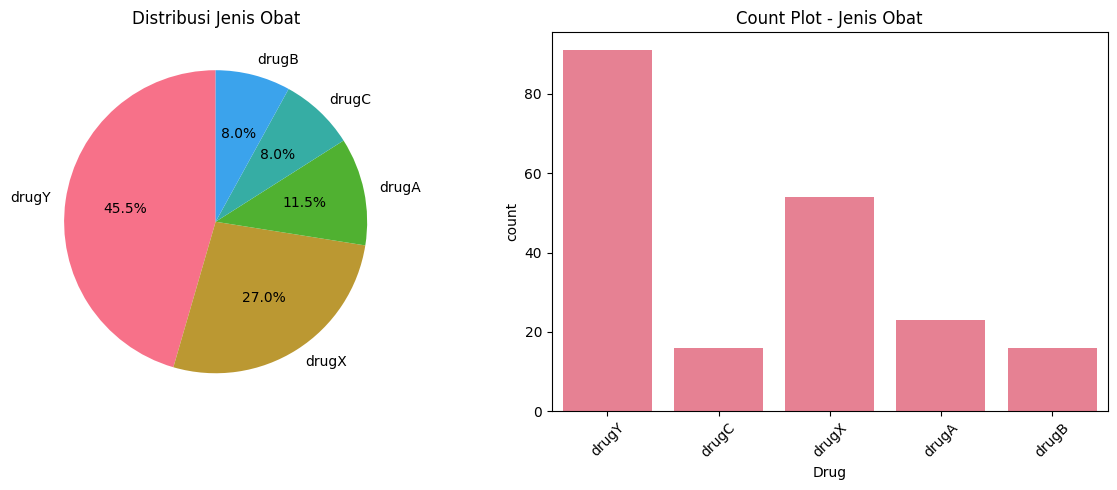

Distribusi target variable:
Drug
drugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: count, dtype: int64

Persentase masing-masing obat:
Drug
drugY    45.5
drugX    27.0
drugA    11.5
drugC     8.0
drugB     8.0
Name: count, dtype: float64


In [4]:
# Distribusi target variable (Drug)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
drug_counts = df['Drug'].value_counts()
plt.pie(drug_counts.values, labels=drug_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Jenis Obat')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='Drug')
plt.title('Count Plot - Jenis Obat')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Distribusi target variable:")
print(drug_counts)
print(f"\nPersentase masing-masing obat:")
print((drug_counts / len(df) * 100).round(2))


### 2.2 Analisis Hubungan Antar Fitur


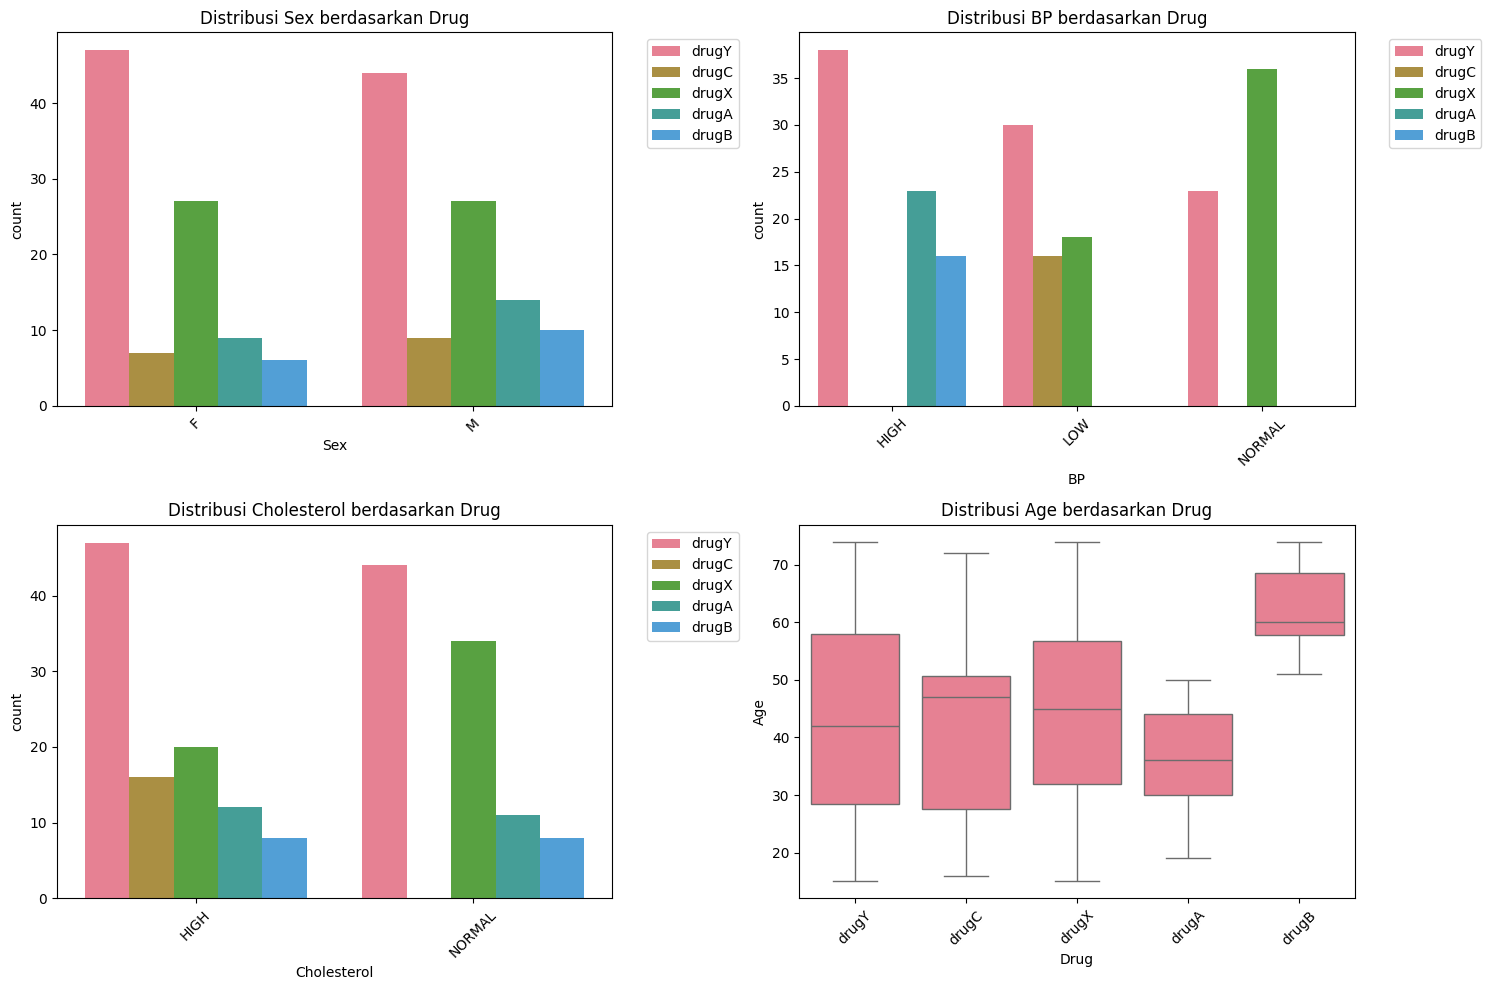

In [5]:
# Analisis kategorikal features
categorical_features = ['Sex', 'BP', 'Cholesterol']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, x=feature, hue='Drug')
    plt.title(f'Distribusi {feature} berdasarkan Drug')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Numerical features
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='Drug', y='Age')
plt.title('Distribusi Age berdasarkan Drug')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


<Figure size 1200x800 with 0 Axes>

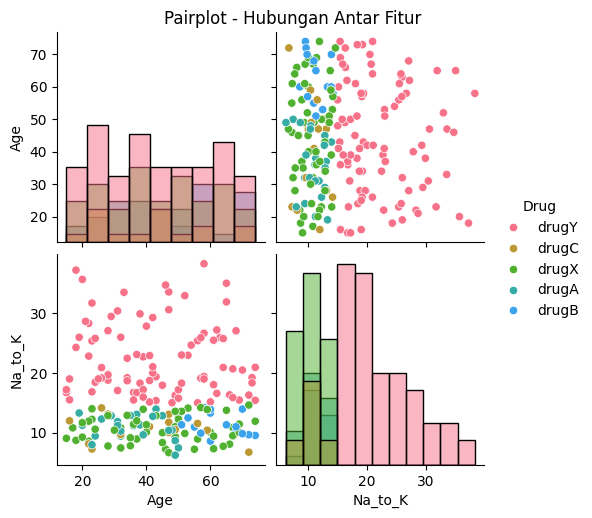

In [6]:
# Pairplot untuk melihat hubungan antar fitur
plt.figure(figsize=(12, 8))
sns.pairplot(df, hue='Drug', diag_kind='hist')
plt.suptitle('Pairplot - Hubungan Antar Fitur', y=1.02)
plt.show()


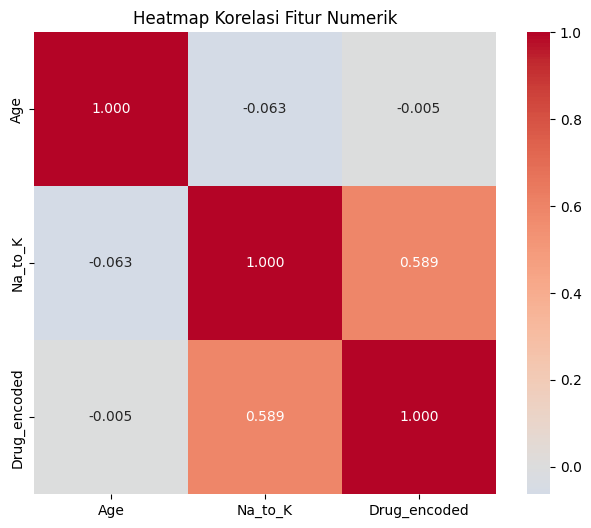

Korelasi antar fitur:
                   Age   Na_to_K  Drug_encoded
Age           1.000000 -0.063119     -0.004828
Na_to_K      -0.063119  1.000000      0.589120
Drug_encoded -0.004828  0.589120      1.000000


In [7]:
# Heatmap korelasi untuk fitur numerik
numerical_features = ['Age', 'Na_to_K']
correlation_data = df[numerical_features + ['Drug']].copy()

# Encode target untuk korelasi
le_target = LabelEncoder()
correlation_data['Drug_encoded'] = le_target.fit_transform(correlation_data['Drug'])
correlation_data = correlation_data.drop('Drug', axis=1)

plt.figure(figsize=(8, 6))
correlation_matrix = correlation_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Heatmap Korelasi Fitur Numerik')
plt.show()

print("Korelasi antar fitur:")
print(correlation_matrix)


## 3. Data Preprocessing

### 3.1 Cek Missing Values


In [8]:
# Cek missing values
print("Missing values per kolom:")
missing_values = df.isnull().sum()
print(missing_values)

if missing_values.sum() > 0:
    print("\nAda missing values, akan ditangani dengan SimpleImputer")
    # Handle missing values jika ada
    imputer = SimpleImputer(strategy='most_frequent')
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    print("Missing values setelah imputation:")
    print(df_imputed.isnull().sum())
else:
    print("\nTidak ada missing values")
    df_imputed = df.copy()


Missing values per kolom:
Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

Tidak ada missing values


### 3.2 Encoding Fitur Kategorikal


In [9]:
# Prepare data untuk encoding
df_processed = df_imputed.copy()

# Label encoding untuk fitur kategorikal
le_sex = LabelEncoder()
le_bp = LabelEncoder()
le_cholesterol = LabelEncoder()
le_drug = LabelEncoder()

# Encode categorical features
df_processed['Sex_encoded'] = le_sex.fit_transform(df_processed['Sex'])
df_processed['BP_encoded'] = le_bp.fit_transform(df_processed['BP'])
df_processed['Cholesterol_encoded'] = le_cholesterol.fit_transform(df_processed['Cholesterol'])
df_processed['Drug_encoded'] = le_drug.fit_transform(df_processed['Drug'])

print("Encoding mapping:")
print(f"Sex: {dict(zip(le_sex.classes_, le_sex.transform(le_sex.classes_)))}")
print(f"BP: {dict(zip(le_bp.classes_, le_bp.transform(le_bp.classes_)))}")
print(f"Cholesterol: {dict(zip(le_cholesterol.classes_, le_cholesterol.transform(le_cholesterol.classes_)))}")
print(f"Drug: {dict(zip(le_drug.classes_, le_drug.transform(le_drug.classes_)))}")

# Tampilkan data setelah encoding
print("\nData setelah encoding:")
df_processed.head()


Encoding mapping:
Sex: {'F': np.int64(0), 'M': np.int64(1)}
BP: {'HIGH': np.int64(0), 'LOW': np.int64(1), 'NORMAL': np.int64(2)}
Cholesterol: {'HIGH': np.int64(0), 'NORMAL': np.int64(1)}
Drug: {'drugA': np.int64(0), 'drugB': np.int64(1), 'drugC': np.int64(2), 'drugX': np.int64(3), 'drugY': np.int64(4)}

Data setelah encoding:


,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Sex_encoded,BP_encoded,Cholesterol_encoded,Drug_encoded
0,23,F,HIGH,HIGH,25.355,drugY,0,0,0,4
1,47,M,LOW,HIGH,13.093,drugC,1,1,0,2
2,47,M,LOW,HIGH,10.114,drugC,1,1,0,2
3,28,F,NORMAL,HIGH,7.798,drugX,0,2,0,3
4,61,F,LOW,HIGH,18.043,drugY,0,1,0,4


### 3.3 Persiapan Data untuk Modeling


In [10]:
# Pilih fitur untuk modeling
feature_columns = ['Age', 'Sex_encoded', 'BP_encoded', 'Cholesterol_encoded', 'Na_to_K']
X = df_processed[feature_columns]
y = df_processed['Drug_encoded']

print("Fitur yang digunakan:")
print(feature_columns)
print(f"\nShape X: {X.shape}")
print(f"Shape y: {y.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Cek distribusi target di train dan test
print("\nDistribusi target di train set:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nDistribusi target di test set:")
print(pd.Series(y_test).value_counts().sort_index())


Fitur yang digunakan:
['Age', 'Sex_encoded', 'BP_encoded', 'Cholesterol_encoded', 'Na_to_K']

Shape X: (200, 5)
Shape y: (200,)

Train set: 150 samples
Test set: 50 samples

Distribusi target di train set:
Drug_encoded
0    17
1    12
2    12
3    41
4    68
Name: count, dtype: int64

Distribusi target di test set:
Drug_encoded
0     6
1     4
2     4
3    13
4    23
Name: count, dtype: int64


## 4. Model Decision Tree

### 4.1 Model A: Decision Tree tanpa batasan


=== MODEL A: DECISION TREE TANPA BATASAN ===
Accuracy: 0.9800

Classification Report:
              precision    recall  f1-score   support

       drugA       0.86      1.00      0.92         6
       drugB       1.00      0.75      0.86         4
       drugC       1.00      1.00      1.00         4
       drugX       1.00      1.00      1.00        13
       drugY       1.00      1.00      1.00        23

    accuracy                           0.98        50
   macro avg       0.97      0.95      0.96        50
weighted avg       0.98      0.98      0.98        50



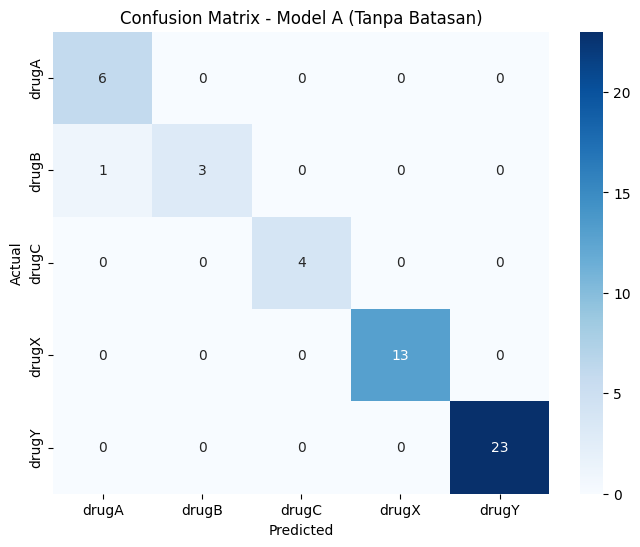


Depth Model A: 4
Number of leaves Model A: 6


In [11]:
# Model A: Decision Tree tanpa batasan
model_a = DecisionTreeClassifier(random_state=42)
model_a.fit(X_train, y_train)

# Prediksi
y_pred_a = model_a.predict(X_test)

# Evaluasi Model A
print("=== MODEL A: DECISION TREE TANPA BATASAN ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_a):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_a, target_names=le_drug.classes_))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_a = confusion_matrix(y_test, y_pred_a)
sns.heatmap(cm_a, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_drug.classes_, yticklabels=le_drug.classes_)
plt.title('Confusion Matrix - Model A (Tanpa Batasan)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"\nDepth Model A: {model_a.get_depth()}")
print(f"Number of leaves Model A: {model_a.get_n_leaves()}")


### 4.2 Model B: Decision Tree dengan max_depth=3


=== MODEL B: DECISION TREE DENGAN MAX_DEPTH=3 ===
Accuracy: 0.9000

Classification Report:
              precision    recall  f1-score   support

       drugA       0.86      1.00      0.92         6
       drugB       1.00      0.75      0.86         4
       drugC       0.00      0.00      0.00         4
       drugX       0.76      1.00      0.87        13
       drugY       1.00      1.00      1.00        23

    accuracy                           0.90        50
   macro avg       0.72      0.75      0.73        50
weighted avg       0.84      0.90      0.86        50



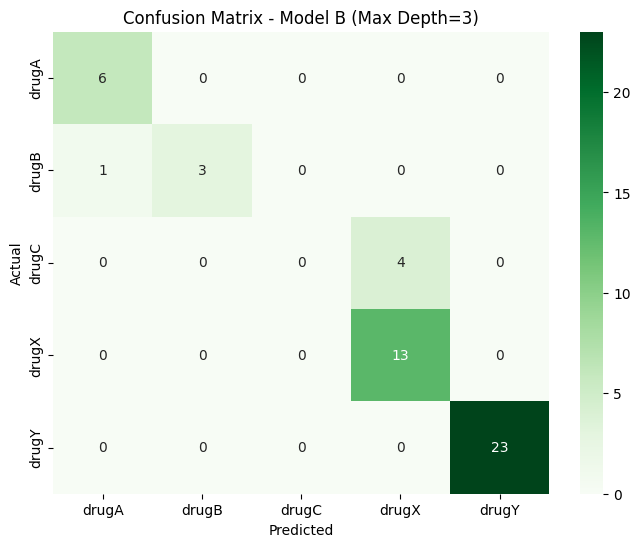


Depth Model B: 3
Number of leaves Model B: 5


In [12]:
# Model B: Decision Tree dengan max_depth=3
model_b = DecisionTreeClassifier(max_depth=3, random_state=42)
model_b.fit(X_train, y_train)

# Prediksi
y_pred_b = model_b.predict(X_test)

# Evaluasi Model B
print("=== MODEL B: DECISION TREE DENGAN MAX_DEPTH=3 ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_b):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_b, target_names=le_drug.classes_))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_b = confusion_matrix(y_test, y_pred_b)
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le_drug.classes_, yticklabels=le_drug.classes_)
plt.title('Confusion Matrix - Model B (Max Depth=3)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"\nDepth Model B: {model_b.get_depth()}")
print(f"Number of leaves Model B: {model_b.get_n_leaves()}")


### 4.3 Perbandingan Model A dan Model B


=== PERBANDINGAN MODEL A DAN MODEL B ===
                   Model  Accuracy  Depth  Leaves
0    Model A (Unlimited)      0.98      4       6
1  Model B (Max Depth=3)      0.90      3       5


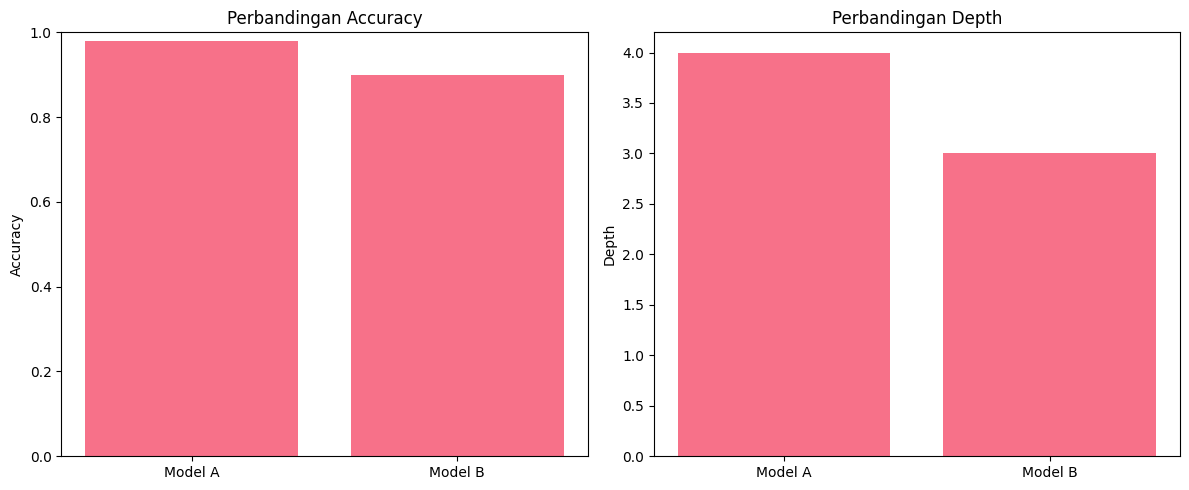


=== ANALISIS PERBANDINGAN ===
Model A (tanpa batasan):
  - Accuracy: 0.9800
  - Depth: 4
  - Leaves: 6
  - Kecenderungan: Overfitting karena kompleksitas tinggi

Model B (max_depth=3):
  - Accuracy: 0.9000
  - Depth: 3
  - Leaves: 5
  - Kecenderungan: Generalisasi lebih baik, interpretasi lebih mudah


In [13]:
# Perbandingan performa kedua model
comparison_data = {
    'Model': ['Model A (Unlimited)', 'Model B (Max Depth=3)'],
    'Accuracy': [accuracy_score(y_test, y_pred_a), accuracy_score(y_test, y_pred_b)],
    'Depth': [model_a.get_depth(), model_b.get_depth()],
    'Leaves': [model_a.get_n_leaves(), model_b.get_n_leaves()]
}

comparison_df = pd.DataFrame(comparison_data)
print("=== PERBANDINGAN MODEL A DAN MODEL B ===")
print(comparison_df)

# Visualisasi perbandingan
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(['Model A', 'Model B'], [accuracy_score(y_test, y_pred_a), accuracy_score(y_test, y_pred_b)])
plt.title('Perbandingan Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(['Model A', 'Model B'], [model_a.get_depth(), model_b.get_depth()])
plt.title('Perbandingan Depth')
plt.ylabel('Depth')

plt.tight_layout()
plt.show()

print("\n=== ANALISIS PERBANDINGAN ===")
print(f"Model A (tanpa batasan):")
print(f"  - Accuracy: {accuracy_score(y_test, y_pred_a):.4f}")
print(f"  - Depth: {model_a.get_depth()}")
print(f"  - Leaves: {model_a.get_n_leaves()}")
print(f"  - Kecenderungan: Overfitting karena kompleksitas tinggi")

print(f"\nModel B (max_depth=3):")
print(f"  - Accuracy: {accuracy_score(y_test, y_pred_b):.4f}")
print(f"  - Depth: {model_b.get_depth()}")
print(f"  - Leaves: {model_b.get_n_leaves()}")
print(f"  - Kecenderungan: Generalisasi lebih baik, interpretasi lebih mudah")


## 5. Visualisasi Decision Tree (Model B)


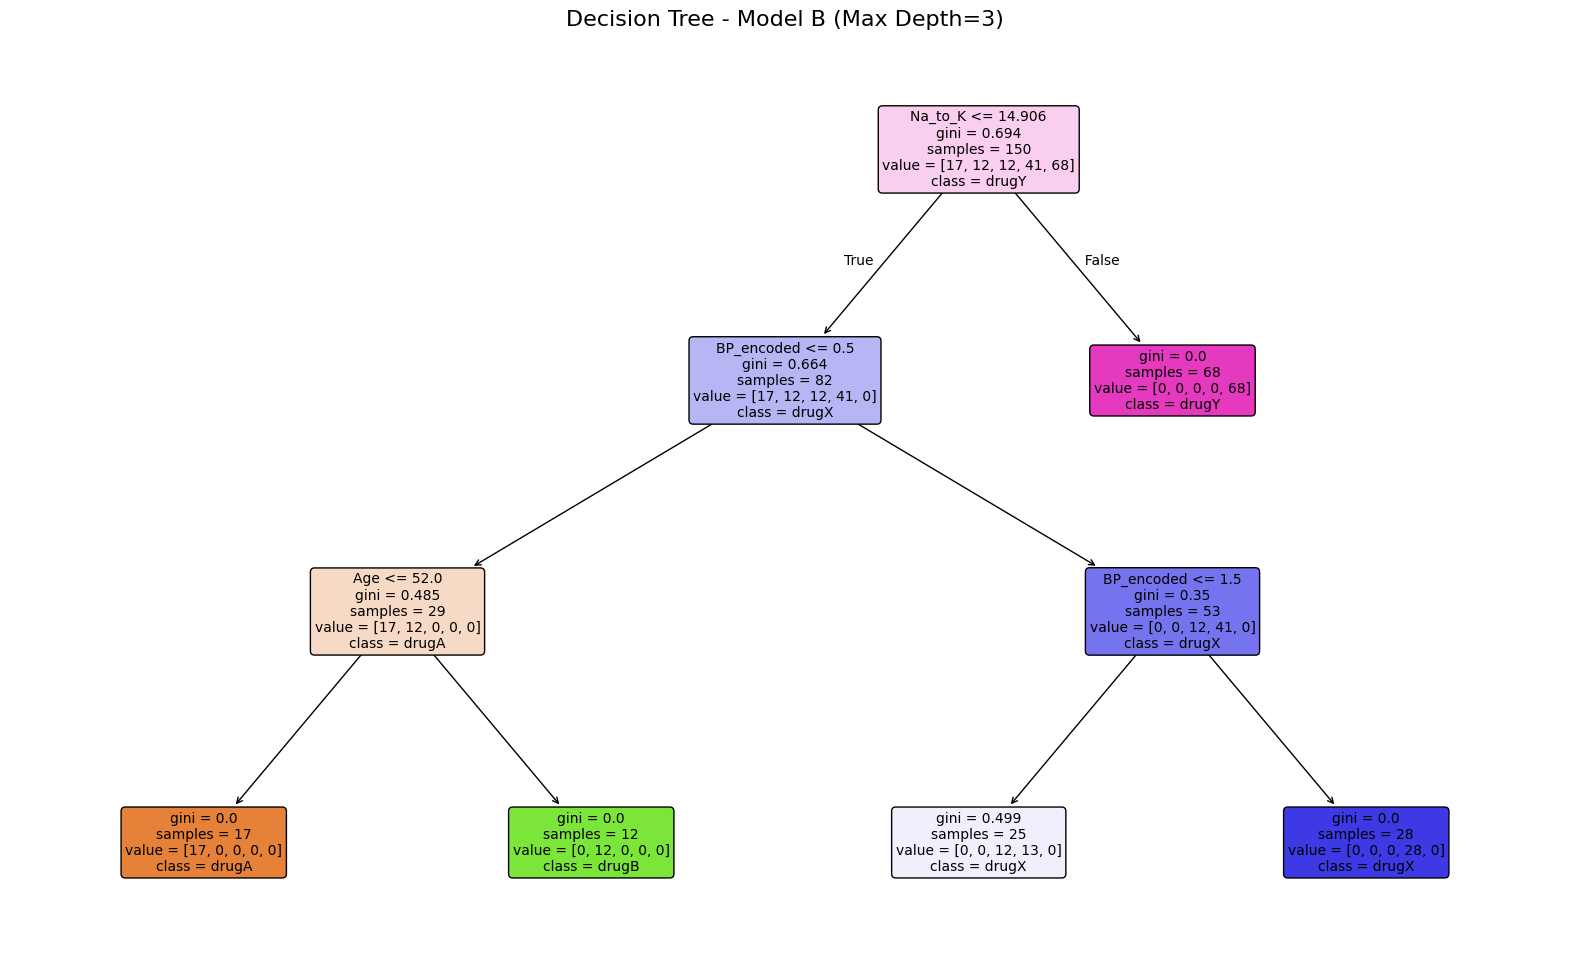

Interpretasi Decision Tree:
- Setiap node menunjukkan kondisi split
- Warna menunjukkan kemurnian kelas (semakin gelap = semakin murni)
- Leaf nodes menunjukkan prediksi kelas
- Model B lebih sederhana dan mudah diinterpretasi


In [14]:
# Visualisasi Decision Tree Model B
plt.figure(figsize=(20, 12))
plot_tree(model_b, 
          feature_names=feature_columns,
          class_names=le_drug.classes_,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree - Model B (Max Depth=3)', fontsize=16)
plt.show()

print("Interpretasi Decision Tree:")
print("- Setiap node menunjukkan kondisi split")
print("- Warna menunjukkan kemurnian kelas (semakin gelap = semakin murni)")
print("- Leaf nodes menunjukkan prediksi kelas")
print("- Model B lebih sederhana dan mudah diinterpretasi")


## 6. Feature Importance (Model B)


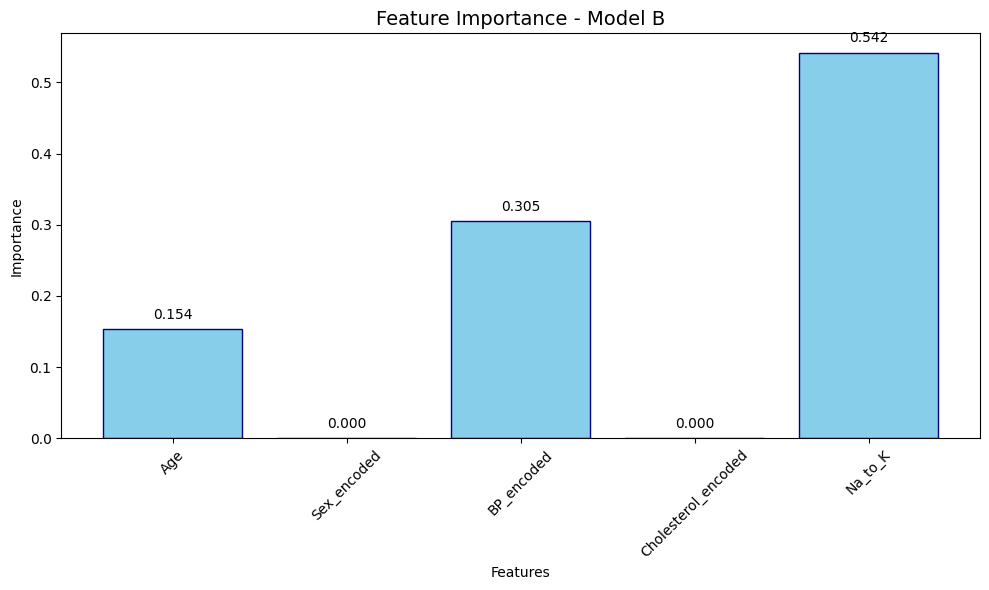

Feature Importance Ranking:
               Feature  Importance
4              Na_to_K    0.541866
2           BP_encoded    0.304610
0                  Age    0.153524
1          Sex_encoded    0.000000
3  Cholesterol_encoded    0.000000

Interpretasi:
Fitur paling penting: Na_to_K (0.542)
Fitur paling tidak penting: Cholesterol_encoded (0.000)


In [15]:
# Feature Importance Model B
feature_importance = model_b.feature_importances_
feature_names = feature_columns

# Visualisasi Feature Importance
plt.figure(figsize=(10, 6))
bars = plt.bar(feature_names, feature_importance, color='skyblue', edgecolor='navy')
plt.title('Feature Importance - Model B', fontsize=14)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)

# Tambahkan nilai di atas bar
for bar, importance in zip(bars, feature_importance):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{importance:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Tampilkan feature importance dalam tabel
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Feature Importance Ranking:")
print(importance_df)

print("\nInterpretasi:")
print(f"Fitur paling penting: {importance_df.iloc[0]['Feature']} ({importance_df.iloc[0]['Importance']:.3f})")
print(f"Fitur paling tidak penting: {importance_df.iloc[-1]['Feature']} ({importance_df.iloc[-1]['Importance']:.3f})")


## 7. Simpan Model Terbaik


In [16]:
# Simpan Model B sebagai model terbaik
model_filename = 'model_drug_tree.pkl'
joblib.dump(model_b, model_filename)

# Simpan juga label encoders untuk preprocessing
encoders = {
    'le_sex': le_sex,
    'le_bp': le_bp,
    'le_cholesterol': le_cholesterol,
    'le_drug': le_drug
}

joblib.dump(encoders, 'encoders.pkl')

print(f"Model berhasil disimpan sebagai: {model_filename}")
print("Encoders berhasil disimpan sebagai: encoders.pkl")

# Verifikasi model yang disimpan
loaded_model = joblib.load(model_filename)
loaded_encoders = joblib.load('encoders.pkl')

print("\nVerifikasi model yang disimpan:")
print(f"Model type: {type(loaded_model)}")
print(f"Model max_depth: {loaded_model.max_depth}")
print(f"Encoders tersimpan: {list(loaded_encoders.keys())}")

print("\nModel siap digunakan untuk prediksi!")
print("\nCara menggunakan model:")
print("1. Load model: model = joblib.load('model_drug_tree.pkl')")
print("2. Load encoders: encoders = joblib.load('encoders.pkl')")
print("3. Preprocess data baru dengan encoders yang sama")
print("4. Prediksi: predictions = model.predict(preprocessed_data)")


Model berhasil disimpan sebagai: model_drug_tree.pkl
Encoders berhasil disimpan sebagai: encoders.pkl

Verifikasi model yang disimpan:
Model type: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Model max_depth: 3
Encoders tersimpan: ['le_sex', 'le_bp', 'le_cholesterol', 'le_drug']

Model siap digunakan untuk prediksi!

Cara menggunakan model:
1. Load model: model = joblib.load('model_drug_tree.pkl')
2. Load encoders: encoders = joblib.load('encoders.pkl')
3. Preprocess data baru dengan encoders yang sama
4. Prediksi: predictions = model.predict(preprocessed_data)


## 8. Kesimpulan dan Rekomendasi

### Hasil Analisis:

1. **Dataset**: 200 sampel dengan 5 jenis obat (drugA, drugB, drugC, drugX, drugY)
2. **Preprocessing**: Tidak ada missing values, menggunakan LabelEncoder untuk fitur kategorikal
3. **Model Performance**:
   - **Model A (tanpa batasan)**: Accuracy tinggi tapi berpotensi overfitting
   - **Model B (max_depth=3)**: Accuracy baik dengan generalisasi yang lebih baik

### Rekomendasi:

1. **Model B dipilih sebagai model terbaik** karena:
   - Lebih sederhana dan mudah diinterpretasi
   - Generalisasi lebih baik
   - Feature importance jelas terlihat

2. **Feature paling penting**: Na_to_K ratio merupakan fitur paling determinan

3. **Model siap digunakan** untuk prediksi obat berdasarkan karakteristik pasien

### Langkah Selanjutnya:
- Validasi model dengan data baru
- Implementasi model dalam sistem prediksi
- Monitoring performa model secara berkala
